# Image Processing CookBook
## Chapter 6
### Author - Sandipan Dey

### Skin-color detection

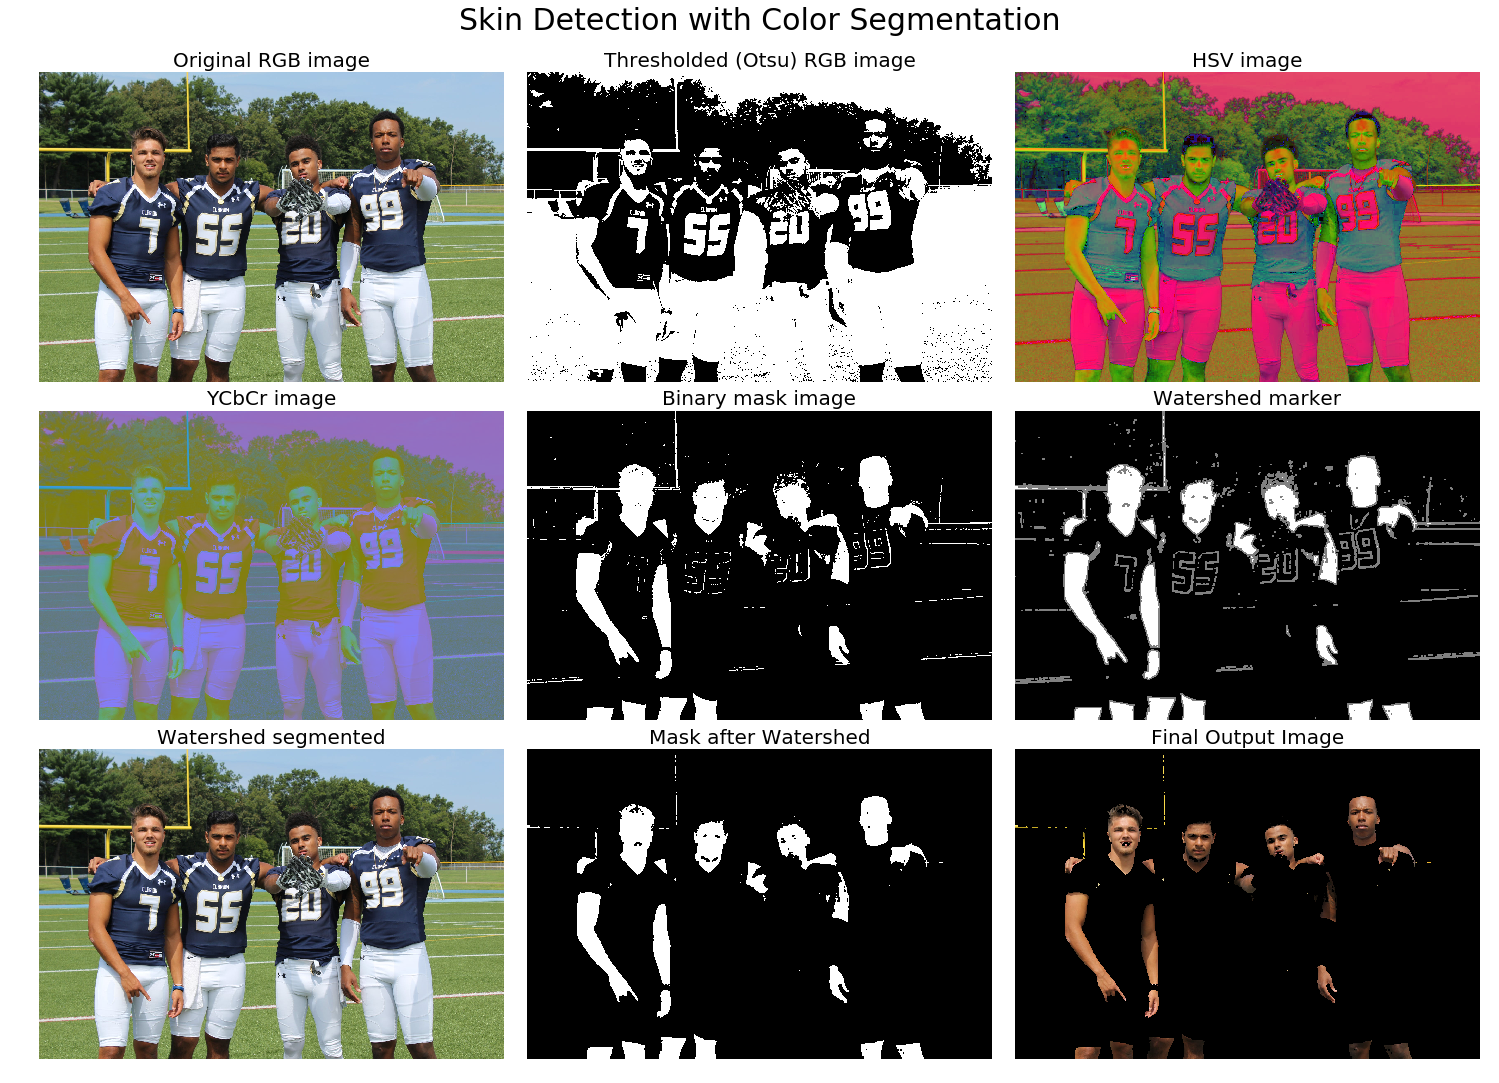

In [53]:
# https://www.researchgate.net/publication/267642008_COLOR-BASED_SKIN_SEGMENTATION_AN_EVALUATION_OF_THE_STATE_OF_THE_ART
% matplotlib inline

import cv2 
import numpy as np
import matplotlib.pylab as plt

def color_segmentation(HSV_image, YCbCr_image):
    lower_HSV_values = np.array([0, 40, 0], dtype = "uint8")
    upper_HSV_values = np.array([25, 255, 255], dtype = "uint8")

    lower_YCbCr_values = np.array((0, 138, 67), dtype = "uint8")
    upper_YCbCr_values = np.array((255, 173, 133), dtype = "uint8")

    #A binary mask is returned. White pixels (255) represent pixels that fall into the upper/lower.
    mask_YCbCr = cv2.inRange(YCbCr_image, lower_YCbCr_values, upper_YCbCr_values)
    mask_HSV = cv2.inRange(HSV_image, lower_HSV_values, upper_HSV_values) 

    binary_mask_image = cv2.add(mask_HSV,mask_YCbCr)
    
    return binary_mask_image

def region_based_segmentation(image, binary_mask_image):
    image_foreground = cv2.erode(binary_mask_image,None,iterations = 3)     	#remove noise
    dilated_binary_image = cv2.dilate(binary_mask_image,None,iterations = 3)   #The background region is reduced a little because of the dilate operation
    ret,image_background = cv2.threshold(dilated_binary_image,1,128,cv2.THRESH_BINARY)  #set all background regions to 128

    image_marker = cv2.add(image_foreground,image_background)   #add both foreground and backgroud, forming markers. The markers are "seeds" of the future image regions.
    image_marker32 = np.int32(image_marker) #convert to 32SC1 format

    cv2.watershed(image,image_marker32)
    m = cv2.convertScaleAbs(image_marker32) #convert back to uint8 

    ret,image_mask = cv2.threshold(m,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    output = cv2.bitwise_and(image,image,mask = image_mask)
    return(output, image_marker, image, image_mask)

image = cv2.imread('images/skin.jpeg')   
_, image_background = cv2.threshold(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY), 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)  #set all background regions to 128
HSV_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
YCbCr_image = cv2.cvtColor(image, cv2.COLOR_BGR2YCR_CB)
binary_mask_image = color_segmentation(HSV_image, YCbCr_image)
output, image_marker, image_watershed, image_mask = region_based_segmentation(image, binary_mask_image)

plt.figure(figsize=(20,15))
plt.gray()
plt.subplots_adjust(left=0, right=1, bottom=0, top=0.925, wspace=0.05, hspace=0.05)
plt.subplot(331), plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)), plt.axis('off'), plt.title('Original RGB image', size=20)
plt.subplot(332), plt.imshow(image_background), plt.axis('off'), plt.title('Thresholded (Otsu) RGB image', size=20)
plt.subplot(333), plt.imshow(cv2.cvtColor(HSV_image, cv2.COLOR_BGR2RGB)), plt.axis('off'), plt.title('HSV image', size=20)
plt.subplot(334), plt.imshow(cv2.cvtColor(YCbCr_image, cv2.COLOR_BGR2RGB)), plt.axis('off'), plt.title('YCbCr image', size=20)
plt.subplot(335), plt.imshow(binary_mask_image), plt.axis('off'), plt.title('Binary mask image', size=20)
plt.subplot(336), plt.imshow(image_marker), plt.axis('off'), plt.title('Watershed marker', size=20)
plt.subplot(337), plt.imshow(cv2.cvtColor(image_watershed, cv2.COLOR_BGR2RGB)), plt.axis('off'), plt.title('Watershed segmented', size=20)
plt.subplot(338), plt.imshow(image_mask), plt.axis('off'), plt.title('Mask after Watershed', size=20)
plt.subplot(339), plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB)), plt.axis('off'), plt.title('Final Output Image', size=20)
plt.suptitle('Skin Detection with Color Segmentation', size=30)
plt.show()


### Skin Color Detection and Segmentation with Gaussian Mixture Model

C:\Users\Sandipan.Dey\Anaconda\envs\ana41py35\lib\site-packages\seaborn\categorical.py:490: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])


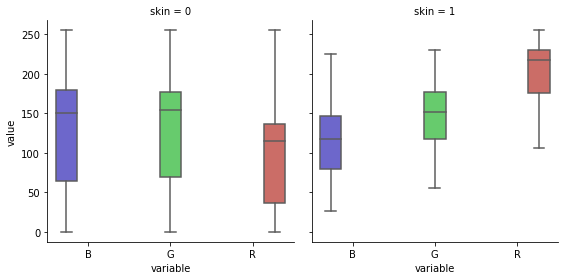

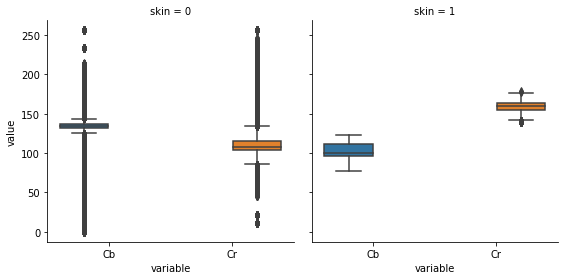

In [143]:
# https://archive.ics.uci.edu/ml/datasets/skin+segmentation

import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
import pandas as pd
import seaborn as sns

df = pd.read_csv('images/Skin_NonSkin.txt', header=None, delim_whitespace=True)
df.columns = ['B', 'G', 'R', 'skin']
df.skin[df.skin == 2] = 0
df.head()

g = sns.factorplot(data=pd.melt(df, id_vars='skin'), x='variable', y='value', \
                   hue='variable', col='skin', kind='box', palette=sns.color_palette("hls", 3)[::-1])
plt.show()

#Y = .299*r + .587*g + .114*b
df['Cb'] = np.round(128 -.168736*df.R -.331364*df.G + .5*df.B).astype(int)
df['Cr'] = np.round(128 +.5*df.R - .418688*df.G - .081312*df.B).astype(int)

df.drop(['B','G','R'], axis=1, inplace=True)
df.head()

g = sns.factorplot(data=pd.melt(df, id_vars='skin'), x='variable', y='value', \
                   hue='variable', col='skin', kind='box')
plt.show()

In [130]:
skin_data = df[df.skin==1].drop(['skin'], axis=1).to_numpy()
not_skin_data = df[df.skin==0].drop(['skin'], axis=1).to_numpy()
skin_gmm = GaussianMixture(n_components=4, covariance_type='full').fit(skin_data)
not_skin_gmm = GaussianMixture(n_components=4, covariance_type='full').fit(not_skin_data)

In [131]:
skin_gmm.means_, skin_gmm.covariances_

(array([[ 90.25565099, 166.90329178],
        [113.65628139, 153.31488736],
        [100.90186428, 157.59816293],
        [ 97.76594338, 162.9252623 ]]), array([[[11.78684623,  0.32071442],
         [ 0.32071442, 12.39168916]],
 
        [[ 9.07233299, -5.39185429],
         [-5.39185429, 17.2473052 ]],
 
        [[14.73841037,  1.61446841],
         [ 1.61446841,  9.32821485]],
 
        [[ 7.59946423,  1.76104197],
         [ 1.76104197,  5.47987745]]]))

In [132]:
not_skin_gmm.means_, not_skin_gmm.covariances_

(array([[135.53030779, 106.14740832],
        [105.19571524, 212.45423154],
        [129.41593341, 124.50408722],
        [124.17816848, 124.87389841]]), array([[[   3.21254604,   -5.05526426],
         [  -5.05526426,   12.98558111]],
 
        [[  84.51406837,  -74.93207731],
         [ -74.93207731,  330.92074287]],
 
        [[   4.19679151,   -6.79119396],
         [  -6.79119396,   17.65532209]],
 
        [[1707.33171585, -308.59805233],
         [-308.59805233, 1236.79593187]]]))

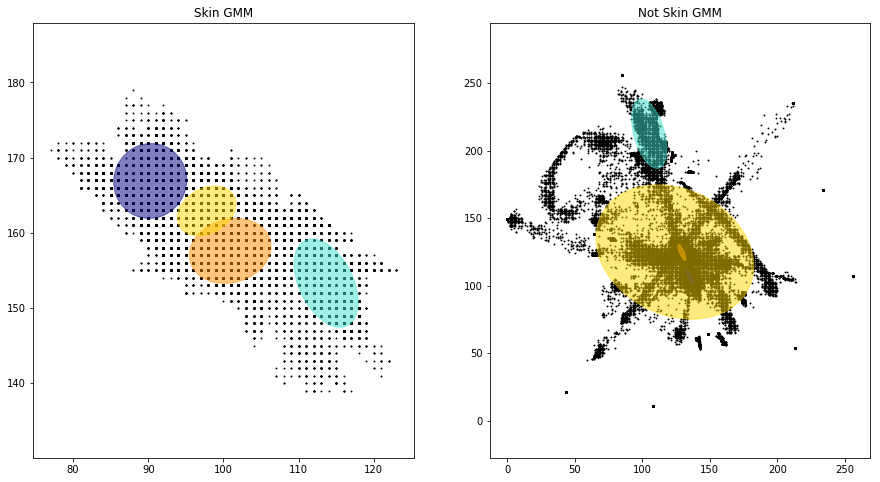

In [144]:
colors = ['navy', 'turquoise', 'darkorange', 'gold']

def make_ellipses(gmm, ax):
    for n, color in enumerate(colors):
        covariances = gmm.covariances_[n][:2, :2]
        v, w = np.linalg.eigh(covariances)
        u = w[0] / np.linalg.norm(w[0])
        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        ell = mpl.patches.Ellipse(gmm.means_[n, :2], v[0], v[1],
                                  180 + angle, color=color)
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)
        ax.set_aspect('equal', 'datalim')

def plot_gmm(gmm, data, i, title):
    h = plt.subplot(1, 2, i)
    make_ellipses(gmm, h)
    plt.scatter(data[:, 0], data[:, 1], s=0.8, color='k')
    plt.title(title)

plt.figure(figsize=(15,8))
plot_gmm(skin_gmm, skin_data, 1, 'Skin GMM')
plot_gmm(not_skin_gmm, not_skin_data, 2, 'Not Skin GMM')
plt.show()    

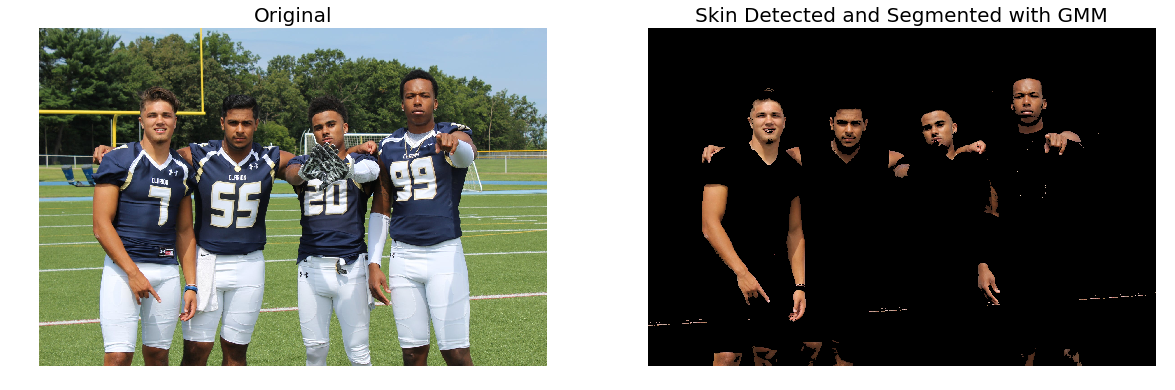

In [142]:
from skimage.io import imread
from skimage.color import rgb2ycbcr, gray2rgb
image = imread('images/skin.jpeg')
proc_image = np.reshape(rgb2ycbcr(image), (-1, 3))
skin_score = skin_gmm.score_samples(proc_image[...,1:])
not_skin_score = not_skin_gmm.score_samples(proc_image[...,1:])
result = skin_score > not_skin_score
result = result.reshape(image.shape[0], image.shape[1])
result = np.bitwise_and(gray2rgb(255*result.astype(np.uint8)), image)
plt.figure(figsize=(20,10))
plt.subplot(121), plt.imshow(image), plt.axis('off'), plt.title('Original', size=20)
plt.subplot(122), plt.imshow(result), plt.axis('off'), plt.title('Skin Detected and Segmented with GMM', size=20)
plt.show()

### Classification of Skin with different binary classifiers

In [46]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
    
df = pd.read_csv('images/Skin_NonSkin.txt', header=None, delim_whitespace=True)
df.columns = ['B', 'G', 'R', 'skin']
df.skin[df.skin == 2] = 0
df['Cb'] = np.round(128 -.168736*df.R -.331364*df.G + .5*df.B).astype(int)
df['Cr'] = np.round(128 +.5*df.R - .418688*df.G - .081312*df.B).astype(int)
df.drop(['B','G','R'], axis=1, inplace=True)
df.drop_duplicates(inplace=True)
df.head()

,skin,Cb,Cr
0,1,116,148
14,1,117,149
45,1,116,149
47,1,115,149
61,1,114,149


In [53]:
def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

(8277, 2) (8277,) 7487 790


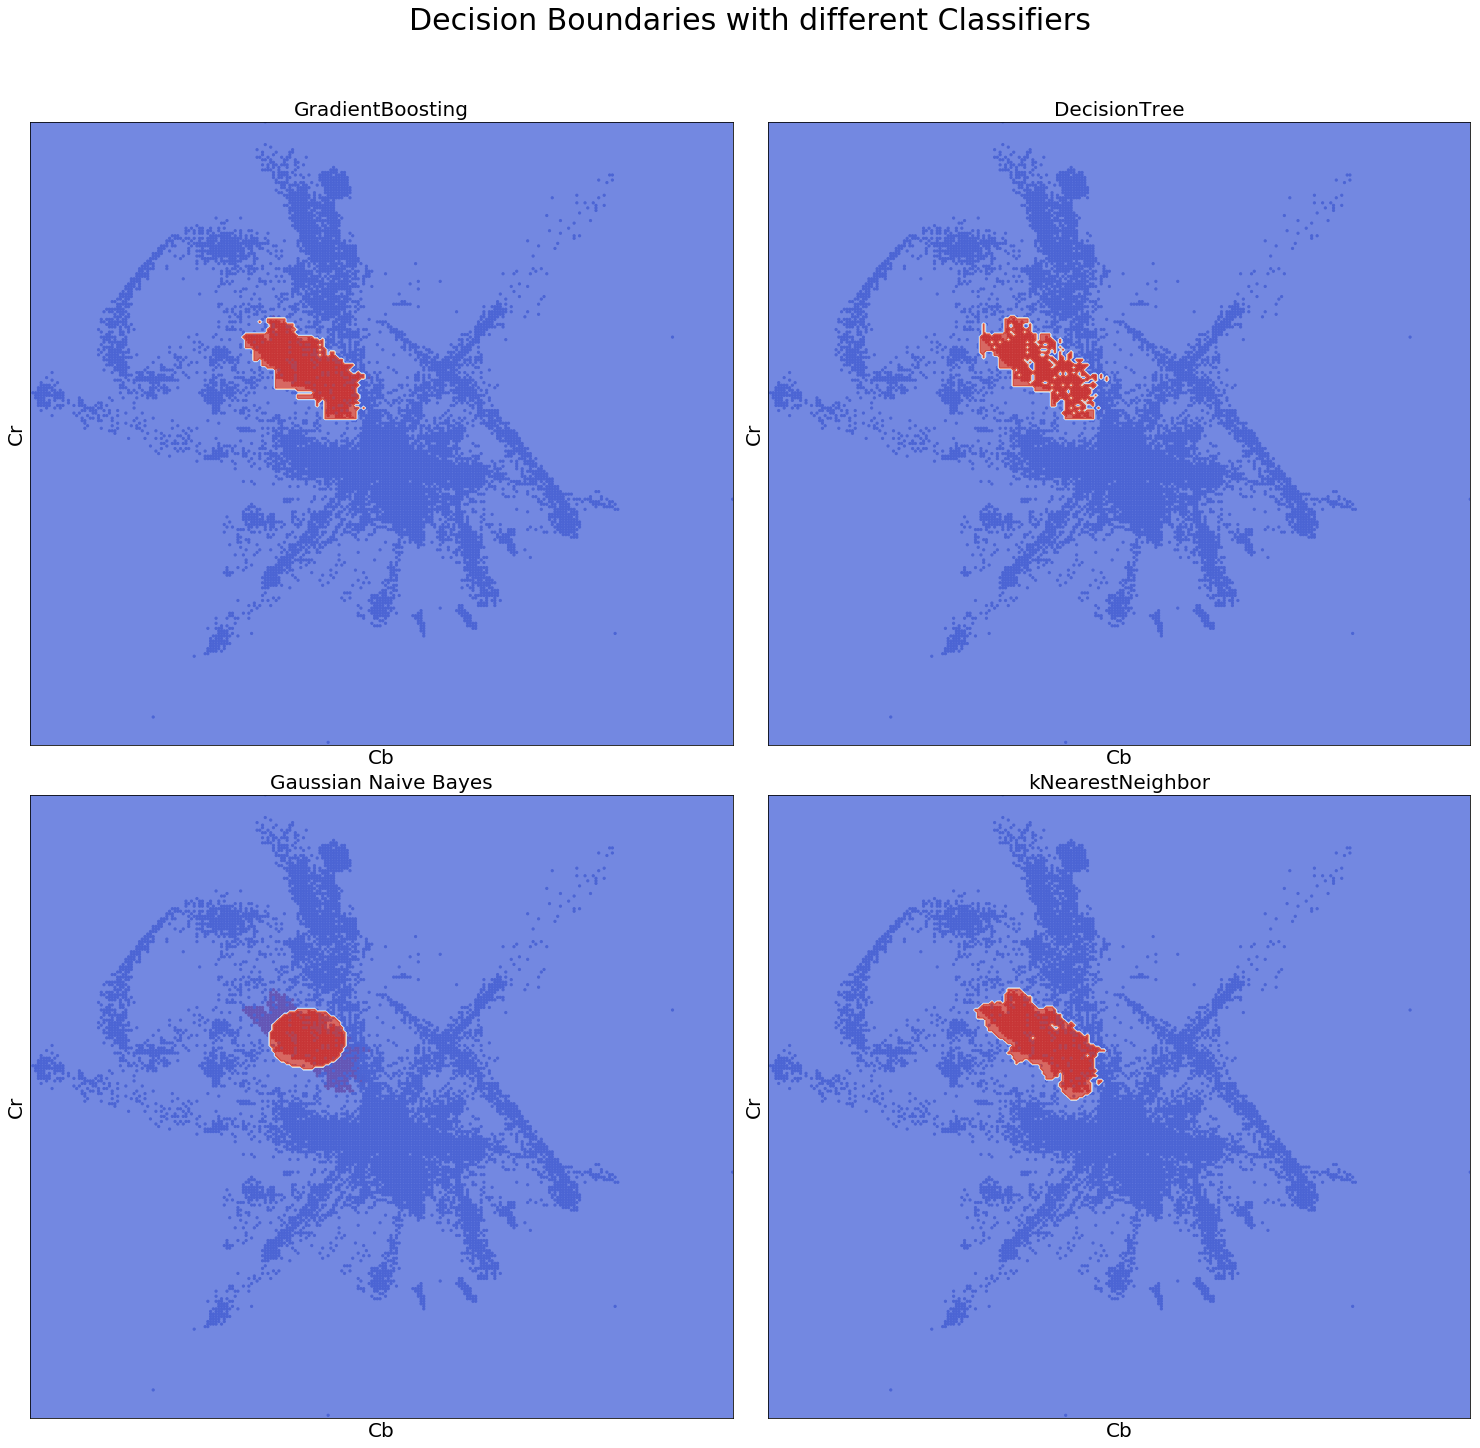

In [56]:
Xy = df.to_numpy()
X = Xy[:, 1:]
y = Xy[:, 0]
#print(X.shape, y.shape, len(y[y==0]), len(y[y==1]))

models = (GradientBoostingClassifier(n_estimators=1000, max_leaf_nodes=4, max_depth=None, random_state=2,
                   min_samples_split=5),
          DecisionTreeClassifier(random_state=0),
          GaussianNB(),
          KNeighborsClassifier(5))
models = [clf.fit(X, y) for clf in models]

# title for the plots
titles = ('GradientBoosting',
          'DecisionTree',
          'Gaussian Naive Bayes',
          'kNearestNeighbor')

# Set-up 2x2 grid for plotting.
fig, sub = plt.subplots(2, 2, figsize=(20,20))
plt.subplots_adjust(left=0, right=1, bottom=0, top=0.9, wspace=0.05, hspace=0.08)

X0, X1 = X[:, 0], X[:, 1]
xx, yy = make_meshgrid(X0, X1, h=1)

for clf, title, ax in zip(models, titles, sub.flatten()):
    ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=5) #, edgecolors='k')
    plot_contours(ax, clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xlabel('Cb', size=20)
    ax.set_ylabel('Cr', size=20)
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title, size=20)

plt.suptitle('Decision Boundaries with different Classifiers', size=30)
plt.show()

GradientBoosting
DecisionTree
Gaussian Naive Bayes
kNearestNeighbor


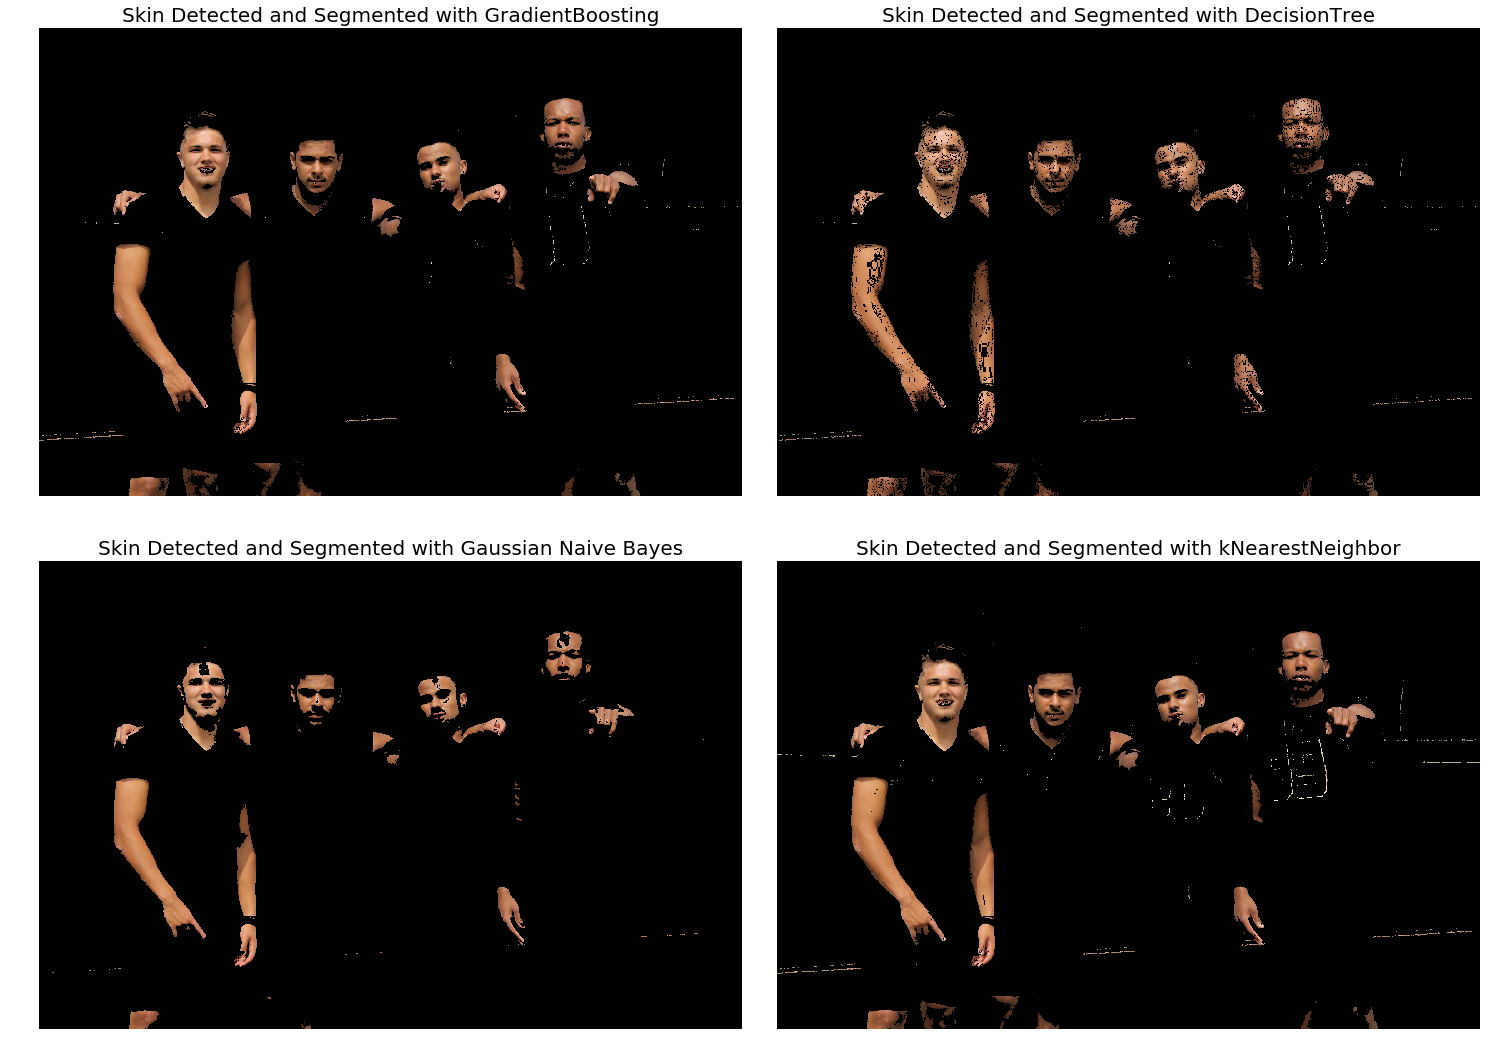

In [64]:
from skimage.io import imread
from skimage.color import rgb2ycbcr, gray2rgb
image = imread('images/skin.jpeg')
proc_image = np.reshape(rgb2ycbcr(image), (-1, 3))

fig, sub = plt.subplots(2, 2, figsize=(20,15))
plt.subplots_adjust(left=0, right=1, bottom=0, top=0.95, wspace=0.05, hspace=0.08)

for clf, title, ax in zip(models, titles, sub.flatten()):
    print(title)
    skin = clf.predict(proc_image[...,1:])
    skin = skin.reshape(image.shape[0], image.shape[1])
    result = np.bitwise_and(gray2rgb(255*skin.astype(np.uint8)), image)
    ax.imshow(result), ax.axis('off'), ax.set_title('Skin Detected and Segmented with ' + title, size=20)
plt.show()